In [1]:
import pandas as pd
import numpy as np
import mediapipe as mp
import cv2
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier


2023-09-08 18:32:40.071304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 18:32:40.931559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils

In [3]:
def make_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(0,255,0),thickness=2,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(0,230,0),thickness=2,circle_radius=1)
                              )
   

Make Face Detection

In [6]:
#check if face is detcting using mediapipe
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.4,min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=make_detection(frame,holistic)
        
        draw_landmarks(image,results)
        cv2.imshow("raw feed",image)
        if cv2.waitKey(10) & 0xFF==ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
#get the total no of coordintes in face
num_coords=len(results.face_landmarks.landmark)
num_coords

468

In [8]:
#get all the headings or feature names for the dataset
landmarks=["class"]
for val in range(1,num_coords+1):
    landmarks+=("x{}".format(val),"y{}".format(val),"z{}".format(val))


In [9]:
#add the feature  names to the csv file 
with open("coords_emotion.csv",mode="w",newline="") as f:
    csv_writer=csv.writer(f,delimiter=",",quotechar='"',quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [59]:
#set the class name
#To add new class to the csv file change class_name value and collect the data for the class
class_name="Neutral"

Collecting data in real time and adding it to the csv file row by row

In [60]:
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.4,min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=make_detection(frame,holistic)
        #print(results)
        draw_landmarks(image,results)
        try:
            face=results.face_landmarks.landmark
            face_row=list(np.array([[lnd.x,lnd.y,lnd.z] for lnd in face]).flatten())
            rows=face_row.copy()
            rows.insert(0,class_name)
            with open("coords_emotion.csv",mode="a",newline="") as f:
                csv_writer=csv.writer(f,delimiter=",",quotechar='"',quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(rows)
        except:
            pass
        cv2.imshow("raw feed",image)
        if cv2.waitKey(10) & 0xFF==ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()

In [65]:
#read dataset
df=pd.read_csv("coords_emotion.csv")
df.tail()

,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z465,x466,y466,z466,x467,y467,z467,x468,y468,z468
1287,Neutral,0.771320,0.387703,-0.027733,0.773549,0.335632,-0.043022,0.771181,0.354727,-0.024633,...,0.008345,0.777071,0.272406,0.001904,0.816823,0.257371,0.024146,0.820732,0.252430,0.024976
1288,Neutral,0.788394,0.389121,-0.027488,0.790966,0.335085,-0.043846,0.788571,0.354238,-0.024724,...,0.007722,0.795799,0.268227,0.001234,0.836502,0.255218,0.024187,0.840314,0.250071,0.025124
1289,Neutral,0.783827,0.388822,-0.026985,0.785620,0.337811,-0.042169,0.783543,0.356107,-0.023934,...,0.007808,0.791406,0.268992,0.001582,0.831380,0.256302,0.023223,0.834962,0.251480,0.024012
1290,Neutral,0.779176,0.388553,-0.027888,0.780985,0.337383,-0.042796,0.778878,0.355992,-0.024426,...,0.008408,0.786441,0.269542,0.002039,0.827017,0.256384,0.024022,0.830686,0.251486,0.024747
1291,Neutral,0.735743,0.397229,-0.026517,0.735304,0.345708,-0.042185,0.734481,0.363493,-0.023591,...,0.006013,0.741768,0.275082,-0.000132,0.783134,0.258304,0.018537,0.786774,0.253099,0.018963


In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [74]:

x=df.drop(["class"],axis="columns")

In [75]:
x

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z465,x466,y466,z466,x467,y467,z467,x468,y468,z468
0,0.743995,0.442625,-0.025758,0.749390,0.400092,-0.045583,0.745694,0.416855,-0.026811,0.737662,...,0.006939,0.749928,0.332933,0.000097,0.787141,0.323273,0.023683,0.791147,0.318417,0.024794
1,0.740803,0.442212,-0.026821,0.744893,0.399966,-0.046092,0.741536,0.416701,-0.027883,0.732783,...,0.008452,0.744830,0.332717,0.001519,0.781533,0.323033,0.026094,0.785347,0.316926,0.027404
2,0.740634,0.444267,-0.025995,0.744593,0.401604,-0.045584,0.741145,0.418058,-0.026919,0.732236,...,0.007466,0.744284,0.332452,0.000564,0.781023,0.321343,0.025034,0.784846,0.315336,0.026273
3,0.740766,0.445659,-0.025923,0.744691,0.402479,-0.045634,0.741365,0.418970,-0.027037,0.732576,...,0.007567,0.744495,0.332753,0.000672,0.780876,0.322296,0.025066,0.784662,0.316370,0.026332
4,0.741069,0.444902,-0.025696,0.745045,0.402071,-0.045515,0.741675,0.418460,-0.026845,0.733042,...,0.007270,0.744919,0.332159,0.000382,0.781431,0.320939,0.024864,0.785195,0.315211,0.026096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,0.771320,0.387703,-0.027733,0.773549,0.335632,-0.043022,0.771181,0.354727,-0.024633,0.762767,...,0.008345,0.777071,0.272406,0.001904,0.816823,0.257371,0.024146,0.820732,0.252430,0.024976
1288,0.788394,0.389121,-0.027488,0.790966,0.335085,-0.043846,0.788571,0.354238,-0.024724,0.780850,...,0.007722,0.795799,0.268227,0.001234,0.836502,0.255218,0.024187,0.840314,0.250071,0.025124
1289,0.783827,0.388822,-0.026985,0.785620,0.337811,-0.042169,0.783543,0.356107,-0.023934,0.776293,...,0.007808,0.791406,0.268992,0.001582,0.831380,0.256302,0.023223,0.834962,0.251480,0.024012
1290,0.779176,0.388553,-0.027888,0.780985,0.337383,-0.042796,0.778878,0.355992,-0.024426,0.771108,...,0.008408,0.786441,0.269542,0.002039,0.827017,0.256384,0.024022,0.830686,0.251486,0.024747


In [76]:
y=df["class"]

In [77]:
#split the dataset in to train and test 
x_train,x_test,y_train,y_test=train_test_split(x.values,y,test_size=0.2,random_state=0)

In [78]:
#create pipelines
pipelines={
    "rf":make_pipeline(StandardScaler(),RandomForestClassifier()),
    "rc":make_pipeline(StandardScaler(),RidgeClassifier()),
    "gb":make_pipeline(StandardScaler(),GradientBoostingClassifier()),
    "lr":make_pipeline(StandardScaler(),LogisticRegression()),
    "svc":make_pipeline(StandardScaler(),SVC()),
    "knn":make_pipeline(StandardScaler(),KNeighborsClassifier())
}

In [80]:
fit_models={}
for algo,pipeline in pipelines.items():
    model=pipeline.fit(x_train,y_train)
    fit_models[algo]=model

/home/ameen/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
fit_models["lr"].score(x_test,y_test)

0.9459459459459459

In [82]:
for algo,model in fit_models.items():
    yhat=model.predict(x_test)
    print(algo,accuracy_score(yhat,y_test))

rf 0.9961389961389961
rc 0.9498069498069498
gb 0.9845559845559846
lr 0.9459459459459459
svc 0.9382239382239382
knn 0.9768339768339769


In [83]:
model=fit_models["rf"]


In [84]:
yhat=fit_models["rf"].predict(x_test)
print(classification_report(yhat,y_test))

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        93
       Happy       1.00      0.96      0.98        27
     Neutral       0.99      1.00      1.00       106
         Sad       1.00      1.00      1.00        33

    accuracy                           1.00       259
   macro avg       1.00      0.99      0.99       259
weighted avg       1.00      1.00      1.00       259



In [85]:
cm=confusion_matrix(yhat,y_test)
model.predict(x_test)

array(['Angry', 'Angry', 'Sad', 'Sad', 'Angry', 'Sad', 'Angry', 'Neutral',
       'Neutral', 'Sad', 'Neutral', 'Neutral', 'Angry', 'Neutral',
       'Angry', 'Angry', 'Neutral', 'Neutral', 'Angry', 'Angry', 'Angry',
       'Happy', 'Neutral', 'Angry', 'Happy', 'Happy', 'Angry', 'Angry',
       'Angry', 'Neutral', 'Happy', 'Neutral', 'Angry', 'Sad', 'Angry',
       'Neutral', 'Neutral', 'Angry', 'Angry', 'Neutral', 'Angry',
       'Happy', 'Happy', 'Neutral', 'Angry', 'Happy', 'Angry', 'Angry',
       'Sad', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Angry',
       'Neutral', 'Neutral', 'Sad', 'Angry', 'Sad', 'Neutral', 'Neutral',
       'Angry', 'Angry', 'Angry', 'Angry', 'Neutral', 'Neutral', 'Angry',
       'Happy', 'Sad', 'Neutral', 'Sad', 'Neutral', 'Neutral', 'Sad',
       'Neutral', 'Neutral', 'Angry', 'Sad', 'Angry', 'Neutral', 'Sad',
       'Neutral', 'Neutral', 'Angry', 'Angry', 'Neutral', 'Neutral',
       'Angry', 'Happy', 'Happy', 'Angry', 'Neutral', 'Sad', 'Neutral',
     

<Axes: >

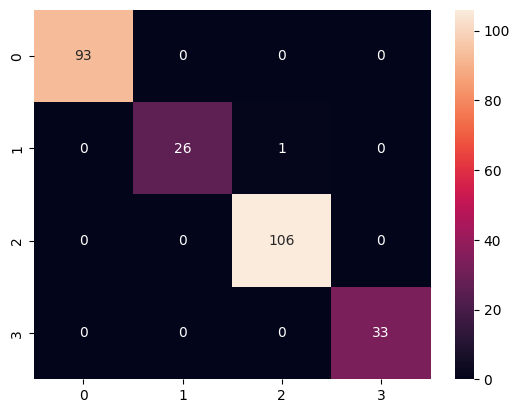

In [87]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt="d")

save the model

In [92]:
import pickle
with open("face_emotion_model.pkl","wb") as f:
    pickle.dump(fit_models["rf"],f)

In [93]:
with open("pose_model.pkl","rb") as f:
    model=pickle.load(f)

In [94]:
model.score(x_test,y_test)

0.9961389961389961

Make Real time predictions

In [40]:
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.4,min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()
        image,results=make_detection(frame,holistic)
        #print(results)
        draw_landmarks(image,results)
        try:
            face=results.face_landmarks.landmark
            #pose_row=list(np.array([[lnd.x,lnd.y,lnd.z,lnd.visibility] for lnd in pose]).flatten())
            face_row=list(np.array([[lnd.x,lnd.y,lnd.z] for lnd in face]).flatten())
            rows=face_row.copy()
            
            body_language_class=model.predict([rows])[0]
            body_language_probab=model.predict_proba([rows])
            #print(model.predict([rows]))
            #coords=tuple(np.multiply(np.array((results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x,results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_EAR].y)),[1280,720]).astype(int))
            #cv2.rectangle(image,(coords[0],coords[1]+5),(coords[0]+len(body_language_class)*20,coords[1]-30),(255,0,0),-1)
            #cv2.putText(image,body_language_class,coords,cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)

            cv2.rectangle(image,(0,0),(250,60),(255,0,0),-1)

            cv2.putText(image,"CLASS",(95,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1,cv2.LINE_AA)

            cv2.putText(image,body_language_class.split(" ")[0],(90,40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)

            cv2.putText(image,"PROB",(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1,cv2.LINE_AA)

            cv2.putText(image,str(round(np.max(body_language_probab),2)),(10,40),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)




            
        except:
            pass
        cv2.imshow("raw feed",image)
        if cv2.waitKey(10) & 0xFF==ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()